In [1]:
# Import packages
import pandas as pd
import numpy as np
import datetime
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, cohen_kappa_score, f1_score
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE, SMOTENC
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.decomposition import PCA
from scipy import stats
from math import sqrt



import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GaussianNoise
from keras.optimizers import SGD
from keras import regularizers

Using TensorFlow backend.


In [2]:
path = "/Users/Stijn/Documents/Master Data Science and Society/Block 3/thesis/code/thesis_Code/"
mood = pd.read_csv(path+'mood_imputed_median.csv', sep = ',', index_col=0)
mood_content = mood.copy()

In [3]:
mood_content['content'].value_counts()

3.0    3972
4.0    2958
2.0    2775
1.0    1559
0.0    1090
5.0     867
Name: content, dtype: int64

In [4]:
contentR2 = []
for a in mood['content']:
    if a == 0:
      contentR2.append(0)  
    if a == 1:
      contentR2.append(2)
    if a == 2:
      contentR2.append(3)
    if a == 3:
      contentR2.append(5)
    if a == 4:
      contentR2.append(7)
    if a == 5:
      contentR2.append(8)
mood_content['contentR2'] = contentR2
mood_content = mood_content.drop(['content'], axis=1)

In [5]:
mood_content['content_last'] = mood_content.groupby('user_id')['contentR2'].shift()
mood_content.loc[(pd.isnull(mood_content.content_last)), 'content_last'] = mood_content['contentR2']
mood_content = mood_content.drop(["anxious", "bored", "cheerful", "user_id", "response_time"], axis=1)
mood_content = mood_content[['contentR2', 'day_time_window', 'average_TimeUse', 'bulk', 'messaging', 'socialnetworking', 'otherapp', 'content_last']]

In [6]:
# Normalize predictors
mood_normz = mood_content.copy()
features_to_normalize = ['day_time_window', 'average_TimeUse', 'messaging', 'socialnetworking', 'otherapp']
mood_normz[features_to_normalize] = mood_normz[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

In [7]:
X = mood_normz.iloc[:,1:]
y = mood_normz.iloc[:, 0:1]
y = y.astype(int)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [9]:
# Oversampling unbalanced target
print("Before OverSampling, counts of labels: {}".format(y_train['contentR2'].value_counts()))
  
sm = SMOTENC(categorical_features=[0, 2, 6], random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train['contentR2'].ravel()) 

print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res == 3))) 
print("After OverSampling, counts of label '4': {}".format(sum(y_train_res == 4))) 
print("After OverSampling, counts of label '5': {}".format(sum(y_train_res == 5))) 
print("After OverSampling, counts of label '7': {}".format(sum(y_train_res == 7))) 
print("After OverSampling, counts of label '9': {}".format(sum(y_train_res == 9))) 

Before OverSampling, counts of labels: 5    3165
7    2379
3    2203
2    1261
0     872
8     696
Name: contentR2, dtype: int64
After OverSampling, counts of label '0': 3165
After OverSampling, counts of label '3': 3165
After OverSampling, counts of label '4': 0
After OverSampling, counts of label '5': 3165
After OverSampling, counts of label '7': 3165
After OverSampling, counts of label '9': 0


In [10]:
X_train = pd.DataFrame(data=X_train_res)
y_train = pd.DataFrame(data=y_train_res)

In [11]:
# Shuffle both train and test set to cancel patterns
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [12]:
X_train_nomood = X_train.iloc[:,:-1]
X_train_onlylastmood = X_train.iloc[:,-1:]
X_test_nomood = X_test.iloc[:,:-1]
X_test_onlylastmood = X_test.iloc[:,-1:]

In [13]:
# Define Keras model
model = Sequential()
model.add(Dense(24, input_dim=6, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                168       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(X_train_nomood, y_train, epochs=100, validation_split=0.2, batch_size=512)

Train on 15192 samples, validate on 3798 samples
Epoch 1/100
15192/15192 [==============================] - 0s 14us/step - loss: 24.9011 - accuracy: 0.1672 - val_loss: 24.3830 - val_accuracy: 0.1646
Epoch 2/100
15192/15192 [==============================] - 0s 5us/step - loss: 22.5064 - accuracy: 0.1568 - val_loss: 21.4429 - val_accuracy: 0.0729
Epoch 3/100
15192/15192 [==============================] - 0s 6us/step - loss: 18.9668 - accuracy: 0.0129 - val_loss: 16.9546 - val_accuracy: 0.0074
Epoch 4/100
15192/15192 [==============================] - 0s 6us/step - loss: 14.1246 - accuracy: 0.0960 - val_loss: 11.9537 - val_accuracy: 0.1598
Epoch 5/100
15192/15192 [==============================] - 0s 5us/step - loss: 10.0482 - accuracy: 0.1526 - val_loss: 8.9530 - val_accuracy: 0.1148
Epoch 6/100
15192/15192 [==============================] - 0s 5us/step - loss: 8.3811 - accuracy: 0.1013 - val_loss: 8.2625 - val_accuracy: 0.1140
Epoch 7/100
15192/15192 [==============================] - 

Epoch 56/100
15192/15192 [==============================] - 0s 4us/step - loss: 7.6987 - accuracy: 0.0190 - val_loss: 7.7086 - val_accuracy: 0.0163
Epoch 57/100
15192/15192 [==============================] - 0s 4us/step - loss: 7.6978 - accuracy: 0.0181 - val_loss: 7.7078 - val_accuracy: 0.0169
Epoch 58/100
15192/15192 [==============================] - 0s 4us/step - loss: 7.6980 - accuracy: 0.0190 - val_loss: 7.7132 - val_accuracy: 0.0142
Epoch 59/100
15192/15192 [==============================] - 0s 4us/step - loss: 7.6971 - accuracy: 0.0186 - val_loss: 7.7084 - val_accuracy: 0.0161
Epoch 60/100
15192/15192 [==============================] - 0s 4us/step - loss: 7.6953 - accuracy: 0.0186 - val_loss: 7.7026 - val_accuracy: 0.0190
Epoch 61/100
15192/15192 [==============================] - 0s 4us/step - loss: 7.6971 - accuracy: 0.0197 - val_loss: 7.7021 - val_accuracy: 0.0182
Epoch 62/100
15192/15192 [==============================] - 0s 4us/step - loss: 7.6943 - accuracy: 0.0188 - val_

In [15]:
score = model.evaluate(X_train_nomood, y_train, verbose=0)
print('Test loss:', round(score[0],4))
print('Test accuracy:', round(score[1]*100,2), "%")

Test loss: 7.6673
Test accuracy: 2.12 %


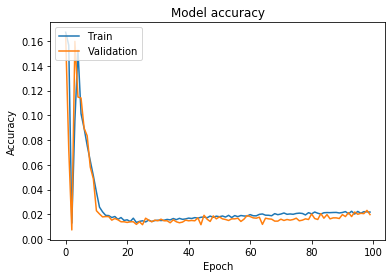

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

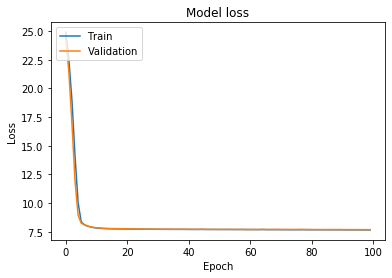

In [17]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
y_pred = model.predict(X_test_nomood)

In [35]:
cat_list = [0,2,3,5,7,8]
pred = []
for a in y_pred:
    for b in a:
        d = min(cat_list, key=lambda x:abs(x-b))
        pred.append(round(d))    

test = []
for c in y_test['contentR2']:
    test.append(c)

In [36]:
test[:5]

[7, 3, 3, 5, 0]

In [37]:
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 29.640831758034025


In [38]:
# true = y_test
# pred = y_pred
# last_value = X_bored_lastarray
same_correct = 0
same_wrong = 0
dif_correct = 0
dif_wrong = 0

X_test_bored = X_test_onlylastmood['content_last'].values
for i in range(len(pred)):
    if (test[i] == X_test_bored[i]) and (test[i] == pred[i]):
        same_correct += 1
    if (test[i] == X_test_bored[i]) and (test[i] != pred[i]):
        same_wrong += 1
    if (test[i] != X_test_bored[i]) and (test[i] == pred[i]):
        dif_correct += 1
    if (test[i] != X_test_bored[i]) and (test[i] != pred[i]):
        dif_wrong += 1   

print("       ", "Same", "Dif")
print("correct", same_correct, dif_correct)
print("wrong  ", same_wrong, dif_wrong)

#Check if table is similar to accuracy
if (same_correct+dif_correct) / (same_correct+dif_correct+same_wrong+dif_wrong) == a:
    print("Table is right!")
else:
    print("Table is wrong")

        Same Dif
correct 489 295
wrong   1172 689
Table is right!


In [39]:
from collections import Counter
print("Predicted valxues: ", Counter(pred))
print("True values: ", Counter(test))
print("Previous mood:", Counter(X_test_bored))

Predicted valxues:  Counter({5: 2443, 3: 191, 2: 6, 7: 4, 0: 1})
True values:  Counter({5: 807, 7: 579, 3: 572, 2: 298, 0: 218, 8: 171})
Previous mood: Counter({5.0: 786, 7.0: 590, 3.0: 576, 2.0: 294, 0.0: 215, 8.0: 184})


In [40]:
same_correct_0, same_wrong_0, same_correct_1, same_wrong_1, same_correct_2, same_wrong_2, same_correct_3, same_wrong_3, same_correct_4, same_wrong_4, same_correct_5, same_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
dif_correct_0, dif_wrong_0, dif_correct_1, dif_wrong_1, dif_correct_2, dif_wrong_2, dif_correct_3, dif_wrong_3, dif_correct_4, dif_wrong_4, dif_correct_5, dif_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] == 0:
        if test[i] == X_test_bored[i]:
            same_correct_0 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_0 += 1
    if test[i] == 0 and pred[i] != 0:
        if test[i] == X_test_bored[i]:
            same_wrong_0 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_0 += 1

    if test[i] == 2 and pred[i] == 2:
        if test[i] == X_test_bored[i]:
            same_correct_1 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_1 += 1
    if test[i] == 2 and pred[i] != 2:
        if test[i] == X_test_bored[i]:
            same_wrong_1 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_1 += 1
        
    if test[i] == 3 and pred[i] == 3:
        if test[i] == X_test_bored[i]:
            same_correct_2 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_2 += 1
    if test[i] == 3 and pred[i] != 3:
        if test[i] == X_test_bored[i]:
            same_wrong_2 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_2 += 1
    
    if test[i] == 5 and pred[i] == 5:
        if test[i] == X_test_bored[i]:
            same_correct_3 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_3 += 1
    if test[i] == 5 and pred[i] != 5:
        if test[i] == X_test_bored[i]:
            same_wrong_3 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_3 += 1
        
    if test[i] == 7 and pred[i] == 7:
        if test[i] == X_test_bored[i]:
            same_correct_4 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_4 += 1
    if test[i] == 7 and pred[i] != 7:
        if test[i] == X_test_bored[i]:
            same_wrong_4 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_4 += 1
    
    if test[i] == 8 and pred[i] == 8:
        if test[i] == X_test_bored[i]:
            same_correct_5 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_5 += 1
    if test[i] == 8 and pred[i] != 8:
        if test[i] == X_test_bored[i]:
            same_wrong_5 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_5 += 1

print("Total length: ", len(X_test_bored))

print("Same Correct 0 guesses is: ", same_correct_0)
print("Same Wrong 0 guesses is: ", same_wrong_0)
print("Dif Correct 0 guesses is: ", dif_correct_0)
print("Dif Wrong 0 guesses is: ", dif_wrong_0)
print('')
print("Same Correct 1 guesses is: ", same_correct_1)
print("Same Wrong 1 guesses is: ", same_wrong_1)
print("Dif Correct 1 guesses is: ", dif_correct_1)
print("Dif Wrong 1 guesses is: ", dif_wrong_1)
print('')
print("Same Correct 2 guesses is: ", same_correct_2)
print("Same Wrong 2 guesses is: ", same_wrong_2)
print("Dif Correct 2 guesses is: ", dif_correct_2)
print("Dif Wrong 2 guesses is: ", dif_wrong_2)
print('')
print("Same Correct 3 guesses is: ", same_correct_3)
print("Same Wrong 3 guesses is: ", same_wrong_3)
print("Dif Correct 3 guesses is: ", dif_correct_3)
print("Dif Wrong 3 guesses is: ", dif_wrong_3)
print('')
print("Same Correct 4 guesses is: ", same_correct_4)
print("Same Wrong 4 guesses is: ", same_wrong_4)
print("Dif Correct 4 guesses is: ", dif_correct_4)
print("Dif Wrong 4 guesses is: ", dif_wrong_4)
print('')
print("Same Correct 5 guesses is: ", same_correct_5)
print("Same Wrong 5 guesses is: ", same_wrong_5)
print("Dif Correct 5 guesses is: ", dif_correct_5)
print("Dif Wrong 5 guesses is: ", dif_wrong_5)

Total length:  2645
Same Correct 0 guesses is:  0
Same Wrong 0 guesses is:  151
Dif Correct 0 guesses is:  0
Dif Wrong 0 guesses is:  67

Same Correct 1 guesses is:  2
Same Wrong 1 guesses is:  157
Dif Correct 1 guesses is:  0
Dif Wrong 1 guesses is:  139

Same Correct 2 guesses is:  13
Same Wrong 2 guesses is:  332
Dif Correct 2 guesses is:  23
Dif Wrong 2 guesses is:  204

Same Correct 3 guesses is:  474
Same Wrong 3 guesses is:  33
Dif Correct 3 guesses is:  272
Dif Wrong 3 guesses is:  28

Same Correct 4 guesses is:  0
Same Wrong 4 guesses is:  388
Dif Correct 4 guesses is:  0
Dif Wrong 4 guesses is:  191

Same Correct 5 guesses is:  0
Same Wrong 5 guesses is:  111
Dif Correct 5 guesses is:  0
Dif Wrong 5 guesses is:  60


In [43]:
mae_0, mae_1, mae_2, mae_3, mae_4, mae_5 = (0,0,0,0,0,0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] != 0:
        mae_0 += (abs(test[i]-pred[i]))
    if test[i] == 2 and pred[i] != 2:
        mae_1 += (abs(test[i]-pred[i]))
    if test[i] == 3 and pred[i] != 3:
        mae_2 += (abs(test[i]-pred[i]))
    if test[i] == 5 and pred[i] != 5:
        mae_3 += (abs(test[i]-pred[i]))
    if test[i] == 7 and pred[i] != 7:
        mae_4 += (abs(test[i]-pred[i]))
    if test[i] == 8 and pred[i] != 8:
        mae_5 += (abs(test[i]-pred[i]))

cnt_0, cnt_1, cnt_2, cnt_3, cnt_4, cnt_5 = (0,0,0,0,0,0)
for z in range(len(test)):
    if test[z] == 0:
        cnt_0 += 1
    if test[z] == 2:
        cnt_1 += 1
    if test[z] == 3:
        cnt_2 += 1
    if test[z] == 5:
        cnt_3 += 1
    if test[z] == 7:
        cnt_4 += 1
    if test[z] == 8:
        cnt_5 += 1

mae_macroaverage = ((mae_0/cnt_0) + (mae_1/cnt_1) + (mae_2/cnt_2) + (mae_3/cnt_3) + (mae_4/cnt_4) + (mae_5/cnt_5)) / 6

In [44]:
print("Macro-averaged Mean Absolute error is: ", round(mae_macroaverage, 4))
print("Macro-averaged F1-score is: ", round(f1_score(test, pred, average='weighted'), 4))

Macro-averaged Mean Absolute error is:  2.4678
Macro-averaged F1-score is:  0.162
